In [1]:
import torch
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.independent import Independent

import time

import matplotlib.pyplot as plt

from flow import NormalizingFlow

In [2]:
torch.manual_seed(42)
n = 20
d = 20
X_no_intercept = torch.randn(n, d - 1)
X = torch.hstack([X_no_intercept, torch.ones(n, 1)])
w = torch.randn(1, d) * 2
σ = 3
y = X @ w.T + torch.randn(n, 1) * σ

In [3]:
xs = torch.linspace(-15, 15, 50)
ys = torch.linspace(-15, 15, 50)
xxs, yys = torch.meshgrid(xs, ys)
xxsyys = torch.hstack([xxs.reshape(-1, 1), yys.reshape(-1, 1)])

/Users/zhihanyang/opt/miniconda3/envs/mlp/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Closed-form posterior inference

In [553]:
w0 = torch.zeros((d, 1))
V0 = torch.eye(d) * 100
V0_inv = torch.eye(d) / 100
VN = (σ ** 2) * torch.linalg.inv((σ ** 2 * V0_inv + X.T @ X))
wN = VN @ V0_inv @ w0 + (1 / σ ** 2) * VN @ X.T @ y

In [554]:
def shift(index):
    if index == 10:
        return 1
    else:
        return index + 1

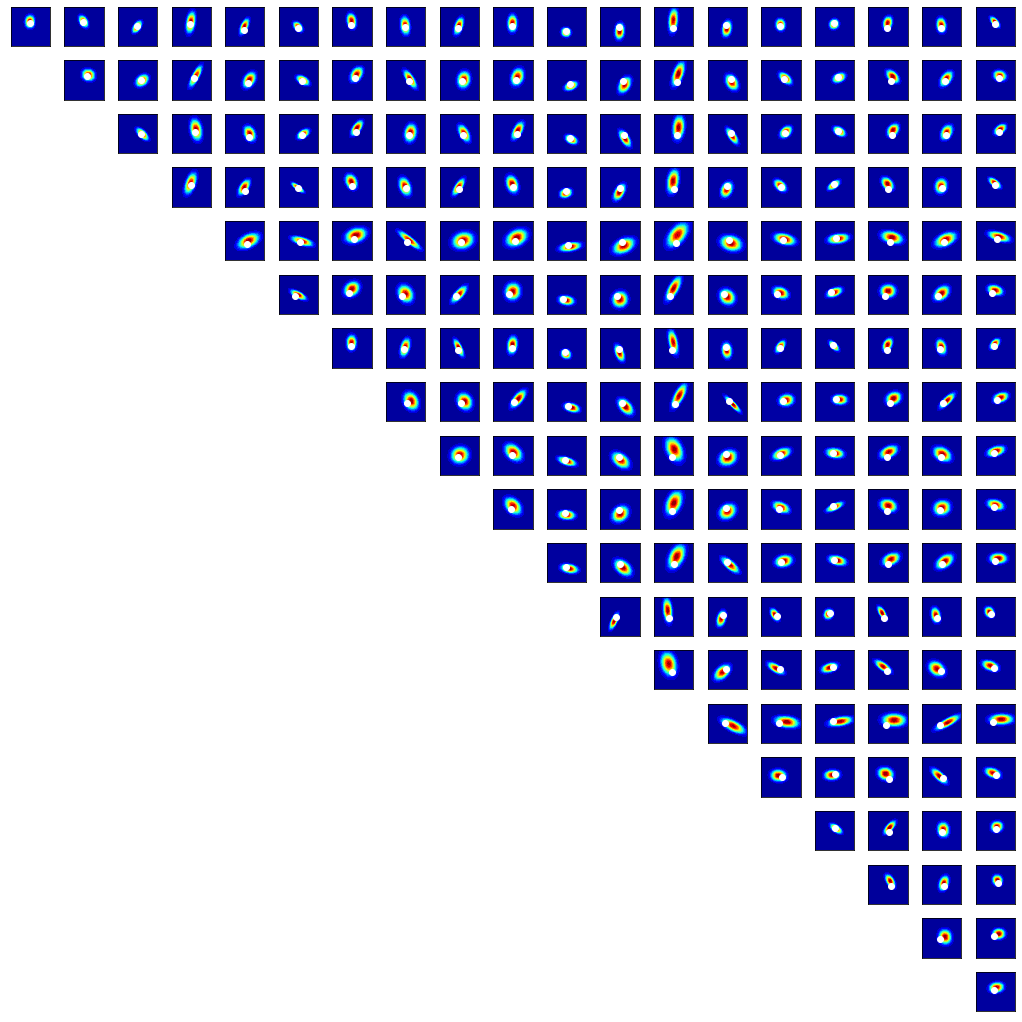

In [555]:
fig = plt.figure(figsize=(15, 15), )
for i in range(1, d+1):
    for j in range(1, d+1):
        if i < j:
            
            fig.add_subplot(d, d, (i-1) * d + j)
            
            marginal = MultivariateNormal(
                loc=torch.Tensor([wN[i-1], wN[j-1]]), 
                covariance_matrix=
                    torch.round(
                        torch.Tensor([[VN[i-1, i-1], VN[i-1, j-1]], [VN[j-1, i-1], VN[j-1, j-1]]]), 
                    decimals=1)  # need to do rounding due to weird numerical imprecisions ??
            )
            
            ps = marginal.log_prob(xxsyys).view(50, 50) #+ marginal2.log_prob(xxsyys).view(50, 50)
            
            plt.contourf(xxs, yys, torch.exp(ps), levels=20, cmap="jet")
            
            plt.scatter([w[0][i-1]], [w[0][j-1]], color="white")
            
            plt.xlim(-15, 15)
            plt.ylim(-15, 15)
            #plt.axis("off")
            plt.xticks([])
            plt.yticks([])
            plt.gca().set_aspect("equal")
        
plt.tight_layout()
        
plt.show()

In [545]:
# from torch.distributions import constraints

In [466]:
# constraints.positive_definite.check(torch.tensor([[3.5670, 0.2076],
#         [0.2076, 6.8822]]))

tensor(True)

## Variational inference with normalizing flows

In [498]:
prior = MultivariateNormal(loc=torch.zeros(d, ), covariance_matrix=torch.eye(d) * 100)

In [499]:
def log_unnormalized_posterior(w):
    model = Independent(Normal(loc=(w @ X.T), scale=σ), 1)
    return prior.log_prob(w) + model.log_prob(y.view(1, -1))

In [501]:
flow = NormalizingFlow(D=d)
opt = optim.Adam(flow.parameters(), lr=1e-2)

start = time.perf_counter()

samples_kls = []

for i in range(1, 10001):
    
    samples_from_q_K, log_probs = flow.sample(n=1000, efficient=True)
    sample_kl = (log_probs - log_unnormalized_posterior(samples_from_q_K)).mean()  # monte-carlo estimate of the kl-divergence
    samples_kls.append(float(sample_kl))
    
    opt.zero_grad()
    sample_kl.backward(retain_graph=True)  # I honestly don't understand why retain_graph=True is needed ...
    opt.step()

    if i % 100 == 0:
        
        print(i, float(sample_kl))
        
        for layer in flow.layers:
            assert (float(layer.u @ layer.w) > -1)
            
end = time.perf_counter()
end - start

100 88.23124694824219
200 87.22088623046875
300 86.986328125
400 86.53784942626953
500 86.47811889648438
600 86.42034912109375
700 86.41877746582031
800 86.25995635986328
900 86.30929565429688
1000 86.29168701171875
1100 86.19047546386719
1200 86.12213134765625
1300 86.15323638916016
1400 86.11115264892578
1500 86.06355285644531
1600 86.02555847167969
1700 86.01215362548828
1800 85.98150634765625


KeyboardInterrupt: 

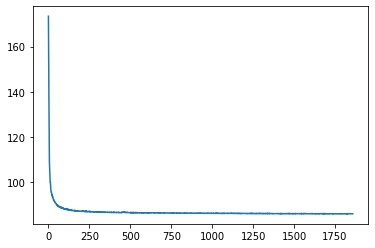

In [502]:
plt.plot(samples_kls)
plt.show()

In [507]:
with torch.no_grad():
    z_K, _ = flow.sample(n=500, efficient=True)

In [508]:
# fig = plt.figure(figsize=(3.5, 3.5))

# i = 7
# j = 10
# marginal = MultivariateNormal(
#     loc=torch.Tensor([wN[i-1], wN[j-1]]), 
#     covariance_matrix=torch.Tensor([[VN[i-1, i-1], VN[i-1, j-1]], [VN[j-1, i-1], VN[j-1, j-1]]])
# )
# ps = torch.exp(marginal.log_prob(xxsyys).view(50, 50))
# plt.contourf(xxs, yys, ps, levels=20, cmap="jet")


# plt.xlim(-10, 10)
# plt.ylim(-10, 10)
# plt.xticks([])
# plt.yticks([])
# plt.show()

# 

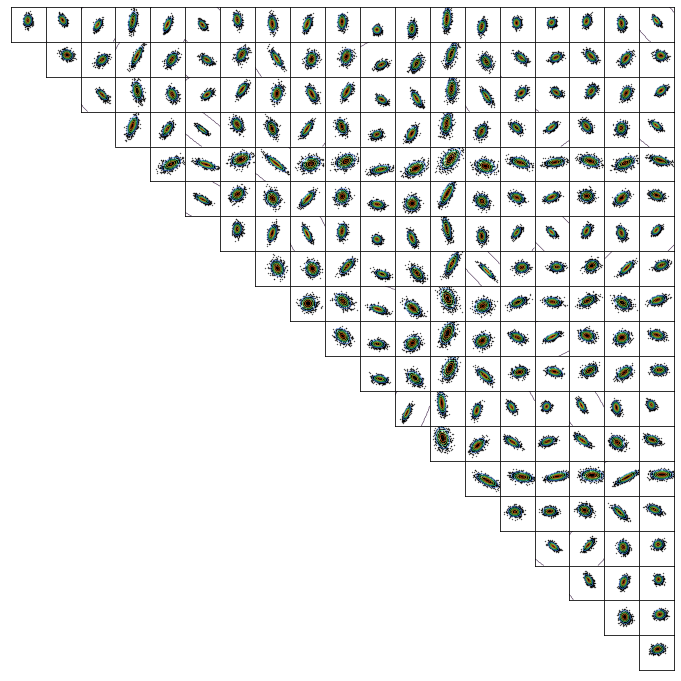

In [528]:
fig = plt.figure(figsize=(10, 10), )
for i in range(1, d+1):
    for j in range(1, d+1):
        if i < j:
            
            fig.add_subplot(d, d, (i-1) * d + j)
            
            marginal = MultivariateNormal(
                loc=torch.Tensor([wN[i-1], wN[j-1]]), 
                covariance_matrix=
                    torch.round(
                        torch.Tensor([[VN[i-1, i-1], VN[i-1, j-1]], [VN[j-1, i-1], VN[j-1, j-1]]]), 
                    decimals=2)  # need to do rounding due to weird numerical imprecisions
            )
            
            ps = marginal.log_prob(xxsyys).view(50, 50) #+ marginal2.log_prob(xxsyys).view(50, 50)
            
            # plt.scatter([w[0][i-1]], [w[0][j-1]], color="white")
            
            plt.scatter(z_K[:,i-1], z_K[:,j-1], s=0.1, alpha=1, color="black")
            
            plt.contour(xxs, yys, torch.exp(ps), levels=5, cmap="turbo", linewidths=0.5)
            
            plt.xlim(-15, 15)
            plt.ylim(-15, 15)
            #plt.axis("off") 
            plt.xticks([])
            plt.yticks([])
            plt.gca().set_aspect("equal")
        
plt.tight_layout() 
fig.subplots_adjust(wspace=0, hspace=0)
        
plt.savefig("10d_bayes_logreg_vi.png", dpi=500)

In [56]:
key_point_1 = torch.Tensor([-5, -5, -5, -5, -5, -5, -5, -5, -5, -5]).view(1, -1)
key_point_2 = torch.Tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]).view(1, -1)
key_point_3 = torch.Tensor([-5, 5, -5, 5, -5, 5, -5, 5, -5, 5]).view(1, -1)

In [57]:
key_point_1[:, [3, 5]]

tensor([[-5., -5.]])

In [58]:
def unnormalized_density_two_dims(x, dim1, dim2):
    return torch.exp(- torch.linalg.vector_norm(x - key_point_1[:, [dim1, dim2]], dim=1)) +\
           torch.exp(- torch.linalg.vector_norm(x - key_point_2[:, [dim1, dim2]], dim=1)) +\
           torch.exp(- torch.linalg.vector_norm(x - key_point_3[:, [dim1, dim2]], dim=1))

In [59]:
def unnormalized_density(x):
    return torch.exp(- torch.linalg.vector_norm(x - key_point_1, dim=1)) +\
           torch.exp(- torch.linalg.vector_norm(x - key_point_2, dim=1)) +\
           torch.exp(- torch.linalg.vector_norm(x - key_point_3, dim=1))

In [60]:
def log_unnormalized_density_two_dims(x, dim1, dim2):
    return torch.logsumexp(torch.hstack([
        - torch.linalg.vector_norm(x - key_point_1[:, [dim1, dim2]], dim=1).view(-1, 1),
        - torch.linalg.vector_norm(x - key_point_2[:, [dim1, dim2]], dim=1).view(-1, 1),
        - torch.linalg.vector_norm(x - key_point_3[:, [dim1, dim2]], dim=1).view(-1, 1)
    ]), dim=1)

In [61]:
def log_unnormalized_density(x):
    return torch.logsumexp(torch.hstack([
        - torch.linalg.vector_norm(x - key_point_1, dim=1).view(-1, 1),
        - torch.linalg.vector_norm(x - key_point_2, dim=1).view(-1, 1),
        - torch.linalg.vector_norm(x - key_point_3, dim=1).view(-1, 1)
    ]), dim=1)

In [62]:
xs = torch.linspace(-15, 15, 50)
ys = torch.linspace(-15, 15, 50)
xxs, yys = torch.meshgrid(xs, ys)
xxsyys = torch.hstack([xxs.reshape(-1, 1), yys.reshape(-1, 1)])

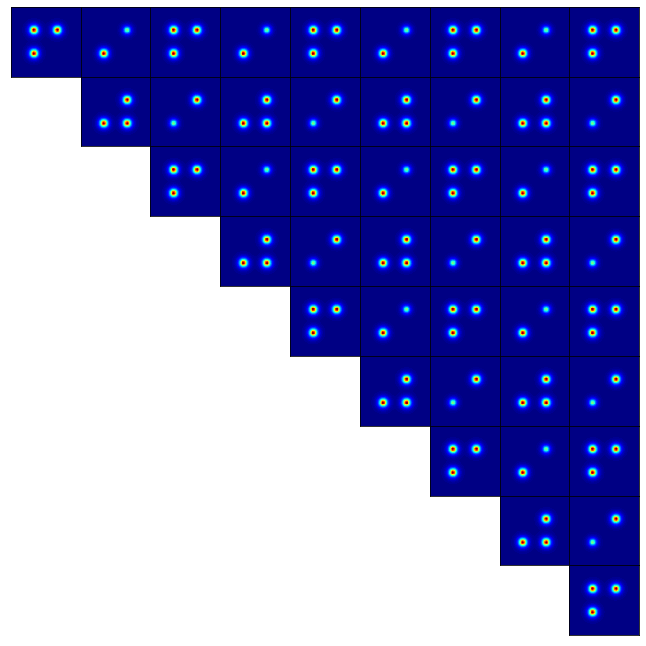

In [104]:
fig = plt.figure(figsize=(10, 10), )
for i in range(1, 10+1):
    for j in range(1, 10+1):
        if i < j:
            
            fig.add_subplot(10, 10, (i-1) * 10 + j)
            
            ps = log_unnormalized_density_two_dims(xxsyys, i-1, j-1).view(50, 50) #+ marginal2.log_prob(xxsyys).view(50, 50)
            
            # plt.scatter([w[0][i-1]], [w[0][j-1]], color="white")
            
            #plt.scatter(z_K[:,i-1], z_K[:,j-1], s=0.1, alpha=1, color="black")
            
            plt.contourf(xxs, yys, torch.exp(ps), levels=100, cmap="jet")
            
            plt.xlim(-15, 15)
            plt.ylim(-15, 15)
            #plt.axis("off") 
            plt.xticks([])
            plt.yticks([])
            plt.gca().set_aspect("equal")
        
plt.tight_layout() 
fig.subplots_adjust(wspace=0, hspace=0)
        
plt.savefig("10d_trimodal_true_density.png", dpi=100, bbox_inches='tight')

In [98]:
#flow = NormalizingFlow(D=10, K=100)
opt = optim.Adam(flow.parameters(), lr=2e-5)

start = time.perf_counter()

samples_kls = []

for i in range(1, 10001):
    
    samples_from_q_K, log_probs = flow.sample(n=2000, efficient=True)
    sample_kl = (log_probs - log_unnormalized_density(samples_from_q_K)).mean()
    
    samples_kls.append(float(sample_kl))
    
    opt.zero_grad()
    sample_kl.backward(retain_graph=True)
    opt.step()

    if i % 100 == 0:
        
        print(i, float(sample_kl))
        
end = time.perf_counter()
end - start

100 -16.967239379882812
200 -16.97930335998535
300 -16.954248428344727
400 -16.964712142944336
500 -16.95791244506836
600 -16.9627742767334
700 -16.963926315307617


KeyboardInterrupt: 

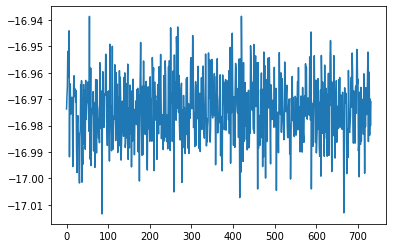

In [99]:
plt.plot(samples_kls)
plt.show()

In [100]:
with torch.no_grad():
    z_K, _ = flow.sample(n=100000, efficient=True)
    z_K = z_K.detach().numpy()

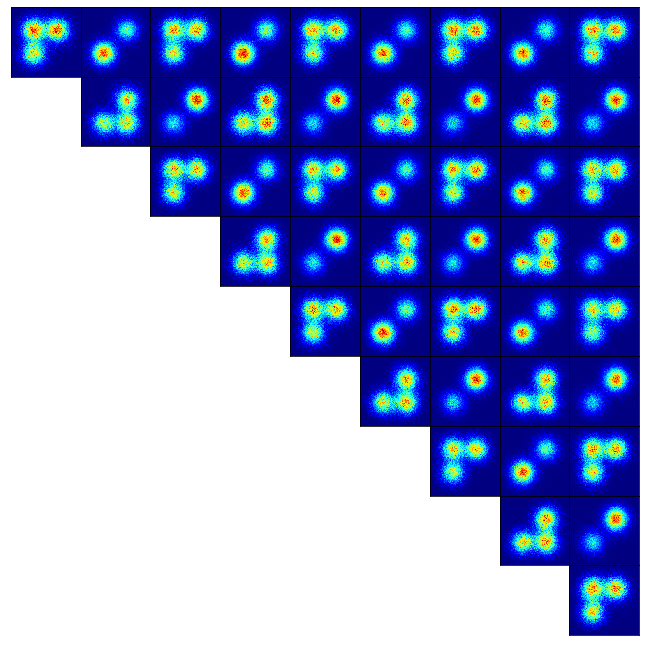

In [103]:
fig = plt.figure(figsize=(10, 10), )
for i in range(1, 10+1):
    for j in range(1, 10+1):
        if i < j:
            
            fig.add_subplot(10, 10, (i-1) * 10 + j)
            
            plt.hist2d(z_K[:,i-1], z_K[:,j-1], bins=100, cmap="jet", range=[[-15, 15], [-15, 15]])
            
            plt.xlim(-15, 15)
            plt.ylim(-15, 15)
            plt.xticks([])
            plt.yticks([])
            plt.gca().set_aspect("equal")
        
plt.tight_layout() 
fig.subplots_adjust(wspace=0, hspace=0)
        
plt.savefig("10d_trimodal_learned_density.png", dpi=100, bbox_inches='tight')